## Chapter 16 Machine Learning Asset Allocation

In [1]:
import numbers
import numpy as np
import scipy as sc
import pandas as pd
import random
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
import matplotlib
import matplotlib.pyplot as plt
from mlfinlab.portfolio_optimization.cla import CLA
from mlfinlab.portfolio_optimization.hrp import HierarchicalRiskParity
from mlfinlab.portfolio_optimization.mean_variance import MeanVarianceOptimisation

%matplotlib inline
np.random.seed(42)

In [2]:
def generateData(nObs = 10000, size0 = 5, size1 = 5, sigma1 = 5):
    
    # Generating some uncorrelated data
    np.random.seed(seed = 12345);random.seed(12345)
    x = np.random.normal(0, 1, size = (nObs, size0)) # each row is a variable
    
    # Creating correlation between the variables
    cols = [random.randint(0, size0 - 1) for i in range(size1)]
    
    # Appending the correlated columns to the dataframe
    y = x[:, cols] + np.random.normal(0, sigma1, size = (nObs, len(cols)))
    x = np.append(x, y, axis = 1)
    x = pd.DataFrame(x, columns = range(1, x.shape[1] + 1))
    
    # Add a column for date
    x['date'] = pd.date_range('01/01/2018', periods = nObs, freq = 'D')
    return x, cols

## Question-16.1

### Given the PnL series on N investment strategies:
### (a) Align them to the average frequency of their bets (e.g., weekly observations for strategies that trade on a weekly basis). Hint: This kind of data alignment is sometimes called “downsampling.”

In [20]:
data, columns = generateData()

In [21]:
data.head()

,1,2,3,4,5,6,7,8,9,10,date
0,-0.204708,0.478943,-0.519439,-0.555730,1.965781,-4.439036,8.764739,3.180197,-3.147956,1.045423,2018-01-01
1,1.393406,0.092908,0.281746,0.769023,1.246435,0.915047,1.201419,3.094260,-5.642867,8.144304,2018-01-02
2,1.007189,-1.296221,0.274992,0.228913,1.352917,-10.725080,1.712924,-6.637815,-1.152876,-7.760446,2018-01-03
3,0.886429,-2.001637,-0.371843,1.669025,-0.438570,0.076896,1.378119,-7.406418,8.289385,-5.914931,2018-01-04
4,-0.539741,0.476985,3.248944,-1.021228,-0.577087,-3.465978,-1.242892,5.619305,3.628232,-3.918065,2018-01-05


We have these 10 investment strategies with their PnL returns on each day starting from 2018-01-01. Lets resample them to create weekly observations (downsampling).

In [22]:
data_downsampled = data.resample('W', on = 'date').mean()
data_downsampled.columns = ['GOOG','AAPL','FB','BABA','AMZN','GE','AMD','WMT','BAC','GM']

In [23]:
data_downsampled.head()

,GOOG,AAPL,FB,BABA,AMZN,GE,AMD,WMT,BAC,GM
date,,,,,,,,,,
2018-01-07,0.279022,-0.396795,0.152563,-0.109974,0.576075,-2.410837,-0.824569,-1.110747,-0.546794,-1.508747
2018-01-14,-0.350800,-0.346207,-0.631422,0.011137,0.096704,0.612525,-1.226492,0.296730,-1.373782,-3.724232
2018-01-21,-0.077386,0.003163,0.081950,0.275069,0.406758,-0.533711,-2.614105,-1.193336,-2.288282,3.200119
2018-01-28,-0.575537,0.031369,0.379820,-0.073842,-0.060659,-2.044900,0.623413,-0.002042,3.628535,-0.593319
2018-02-04,-0.041148,0.070309,0.191776,0.384258,-0.034658,0.888154,-0.802273,-1.617831,-1.022630,2.327756


### (b) Compute the covariance of their returns, V

In [24]:
V = data_downsampled.cov()

In [25]:
V

,GOOG,AAPL,FB,BABA,AMZN,GE,AMD,WMT,BAC,GM
GOOG,0.141747,0.002473,0.003713,-0.002615,0.001359,-0.004667,0.158400,-0.008894,0.024740,-0.054863
AAPL,0.002473,0.143569,-0.004477,0.004449,0.002685,-0.003948,-0.007377,-0.017840,-0.024780,0.150928
FB,0.003713,-0.004477,0.143311,-0.000607,-0.001428,0.002474,-0.030026,0.148989,0.183264,0.003275
BABA,-0.002615,0.004449,-0.000607,0.139844,-0.002519,0.166996,0.004417,-0.002265,-0.002306,0.017298
AMZN,0.001359,0.002685,-0.001428,-0.002519,0.136606,0.011441,-0.009717,0.001093,0.012710,0.014721
GE,-0.004667,-0.003948,0.002474,0.166996,0.011441,3.809152,-0.065955,-0.011416,-0.047105,-0.039467
AMD,0.158400,-0.007377,-0.030026,0.004417,-0.009717,-0.065955,3.623063,-0.165723,-0.027640,-0.197081
WMT,-0.008894,-0.017840,0.148989,-0.002265,0.001093,-0.011416,-0.165723,4.009096,0.028208,0.110969
BAC,0.024740,-0.024780,0.183264,-0.002306,0.012710,-0.047105,-0.027640,0.028208,3.872228,-0.003318
GM,-0.054863,0.150928,0.003275,0.017298,0.014721,-0.039467,-0.197081,0.110969,-0.003318,3.743662


### (c) Identify the hierarchical clusters among the N strategies

In [26]:
correlation = data_downsampled.corr()
distances = np.sqrt((1 - correlation) / 2)
clusters = linkage(squareform(distances), method = "single")
clusters

array([[ 2.        ,  8.        ,  0.61399822,  2.        ],
       [ 3.        ,  5.        ,  0.62096374,  2.        ],
       [ 0.        ,  6.        ,  0.62408531,  2.        ],
       [ 1.        ,  9.        ,  0.63013091,  2.        ],
       [ 7.        , 10.        ,  0.63381484,  3.        ],
       [12.        , 14.        ,  0.6952002 ,  5.        ],
       [11.        , 13.        ,  0.69591833,  4.        ],
       [15.        , 16.        ,  0.69690614,  9.        ],
       [ 4.        , 17.        ,  0.69979115, 10.        ]])

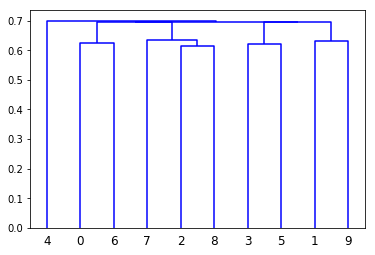

In [27]:
dendrogram(clusters)
plt.show()

### (d) Plot the clustered correlation matrix of the N strategies

Lets plot the unclustered correlation matrix first

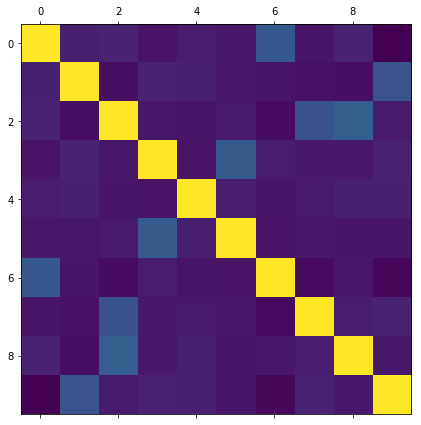

In [28]:
plt.figure(figsize=(7, 7))
plt.matshow(data_downsampled.corr(), fignum=1)
plt.show()

Now, lets rearrange the above matrix based on the hierarchical clusters found in the previous step. This is called **matrix seriation**. This is implemented in mlfinlab's HRP implementation and we will directly use it for this question

In [29]:
hrp = HierarchicalRiskParity()
hrp.allocate(asset_prices = data_downsampled)

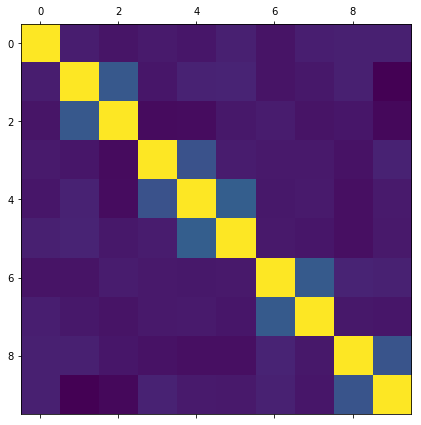

In [30]:
plt.figure(figsize = (7, 7))
plt.matshow(hrp.seriated_correlations, fignum = 1)
plt.show()

We observe that the correlation matrix has been regrouped in such a way that assets with similar correlations are present together in a cluster.

## Question-16.2

### Using the clustered covariance matrix V from exercise 1:

### (a) Compute the HRP allocations

In [31]:
hrp = HierarchicalRiskParity()
hrp.allocate(asset_prices=data_downsampled)
hrp.weights

,AMZN,GOOG,AMD,WMT,FB,BAC,BABA,GE,AAPL,GM
0,0.205213,0.197771,0.007949,0.006703,0.187502,0.007086,0.196208,0.007212,0.177549,0.006809


### (b) Compute the CLA allocations

In [32]:
cla = CLA()
cla.allocate(asset_prices=data_downsampled, solution='cla_turning_points')
cla.weights

,GOOG,AAPL,FB,BABA,AMZN,GE,AMD,WMT,BAC,GM
0,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000
1,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000
2,0.000000,0.000000,1.734723e-18,0.000000,0.988025,0.011975,0.000000e+00,0.000000e+00,0.0,0.000000
3,0.000000,0.000000,5.392337e-02,0.000000,0.933641,0.012436,-2.168404e-18,0.000000e+00,0.0,0.000000
4,0.000000,0.000000,8.751452e-02,0.000000,0.897849,0.012723,1.913543e-03,0.000000e+00,0.0,0.000000
5,0.000000,0.000000,1.270483e-01,0.056326,0.802493,0.009921,4.211749e-03,0.000000e+00,0.0,0.000000
6,0.000000,0.031697,1.440485e-01,0.081891,0.728767,0.008282,5.314938e-03,0.000000e+00,0.0,0.000000
7,0.141380,0.148975,1.871876e-01,0.174606,0.344394,0.000736,2.721600e-03,0.000000e+00,0.0,0.000000
8,0.183529,0.183040,1.999404e-01,0.200239,0.230487,0.000000,2.011310e-03,1.084202e-19,0.0,0.000754
9,0.191794,0.189819,2.014034e-01,0.205073,0.208148,0.000000,1.908539e-03,9.821841e-04,0.0,0.000872


### Compute the IVP allocations

In [33]:
mvo = MeanVarianceOptimisation()
mvo.allocate(asset_prices=data_downsampled, solution='inverse_variance')
mvo.weights

,GOOG,AAPL,FB,BABA,AMZN,GE,AMD,WMT,BAC,GM
0,0.191799,0.189365,0.189705,0.194409,0.199017,0.007137,0.007504,0.006781,0.007021,0.007262


## Question-16.3

### (a) Perform a spectral decomposition: VW=W$\wedge$

In [39]:
N = data_downsampled.shape[1]

In [34]:
eigenvalues, eigenvectors = np.linalg.eig(V)

In [35]:
eigenvalues_matrix = np.identity(n = data_downsampled.shape[1]) * eigenvalues

In [36]:
eigenvalues_matrix

array([[4.16339086, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 3.45350652, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 3.9041559 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 3.76419502, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 3.80912291,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.12394202, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.12791168, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

### (b) Form an array $\epsilon$ by drawing N random numbers from U[0, 1] distribution

In [37]:
epsilon = np.random.uniform(low = 0, high = 1, size = data_downsampled.shape[1])
epsilon

array([0.41691221, 0.41350794, 0.65183833, 0.02248446, 0.20396791,
       0.44022456, 0.32081029, 0.89442157, 0.83399797, 0.20954313])

### (c) Form an NxN matrix $\wedge^{'}$, where $\wedge^{'}_{n,n}=N\epsilon_{n}\wedge_{n,n}(\sum\epsilon_{n})^{-1}, n=1....N$

In [40]:
eigenvalues_matrix_modified = (N * epsilon * eigenvalues_matrix)/np.sum(epsilon)

In [41]:
eigenvalues_matrix_modified

array([[3.93802931, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 3.23989761, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 5.77369976, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.19201787, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.76268203,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.12378841, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.09309913, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

### (d) Compute $V^{'}=W\wedge^{'}W^{-1}$

In [42]:
V_modified = eigenvectors @ eigenvalues_matrix_modified @ np.linalg.inv(eigenvectors)

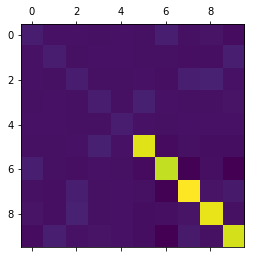

In [43]:
plt.matshow(V)
plt.show()

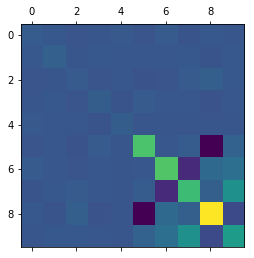

In [44]:
plt.matshow(V_modified)
plt.show()

### (e) Repeat exercise 2, this time using $V^{'}$ as covariance matrix. What allocation method has been most impacted by the re-scaling of spectral variances?

### (i) HRP

In [45]:
class HierarchicalRiskParityModified:

    def __init__(self):
        return

    def _tree_clustering(self, correlation, method='single'):
        '''
        Perform the traditional heirarchical tree clustering

        :param correlation: (np.array) correlation matrix of the assets
        :param method: (str) the type of clustering to be done
        :return: distance matrix and clusters
        '''

        distances = np.sqrt((1 - correlation) / 2)
        clusters = linkage(squareform(distances.values), method=method)
        return distances, clusters

    def _quasi_diagnalization(self, N, curr_index):
        '''
        Rearrange the assets to reorder them according to hierarchical tree clustering order.

        :param N: (int) index of element in the cluster list
        :param curr_index: (int) current index
        :return: (list) the assets rearranged according to hierarchical clustering
        '''

        if curr_index < N:
            return [curr_index]

        left = int(self.clusters[curr_index - N, 0])
        right = int(self.clusters[curr_index - N, 1])

        return (self._quasi_diagnalization(N, left) + self._quasi_diagnalization(N, right))

    def _get_seriated_matrix(self, assets, distances, correlations):
        '''
        Based on the quasi-diagnalization, reorder the original distance matrix, so that assets within
        the same cluster are grouped together.

        :param assets:
        :param distances:
        :param correlations:
        :return: (np.array) re-arranged distance matrix based on tree clusters
        '''

        ordering = assets[self.ordered_indices]
        seriated_distances = distances.loc[ordering, ordering]
        seriated_correlations = correlations.loc[ordering, ordering]
        return seriated_distances, seriated_correlations

    def _recursive_bisection(self, covariances, assets):
        '''
        Recursively assign weights to the clusters - ultimately assigning weights to the inidividual assets

        :param covariances: (np.array) the covariance matrix
        :param assets:
        '''

        self.weights = pd.Series(1, index=self.ordered_indices)
        clustered_alphas = [self.ordered_indices]

        while len(clustered_alphas) > 0:
            clustered_alphas = [cluster[start:end]
                                for cluster in clustered_alphas
                                for start, end in ((0, len(cluster) // 2), (len(cluster) // 2, len(cluster)))
                                if len(cluster) > 1]

            for subcluster in range(0, len(clustered_alphas), 2):
                left_cluster = clustered_alphas[subcluster]
                right_cluster = clustered_alphas[subcluster + 1]

                # Get left cluster variance
                left_subcovar = covariances.iloc[left_cluster, left_cluster]
                inv_diag = 1 / np.diag(left_subcovar.values)
                parity_w = inv_diag * (1 / np.sum(inv_diag))
                left_cluster_var = np.dot(parity_w, np.dot(left_subcovar, parity_w))

                # Get right cluster variance
                right_subcovar = covariances.iloc[right_cluster, right_cluster]
                inv_diag = 1 / np.diag(right_subcovar.values)
                parity_w = inv_diag * (1 / np.sum(inv_diag))
                right_cluster_var = np.dot(parity_w, np.dot(right_subcovar, parity_w))

                # Calculate allocation factor and weights
                alloc_factor = 1 - left_cluster_var / (left_cluster_var + right_cluster_var)
                self.weights[left_cluster] *= alloc_factor
                self.weights[right_cluster] *= 1 - alloc_factor

        # Assign actual asset values to weight index
        self.weights.index = assets[self.ordered_indices]
        self.weights = pd.DataFrame(self.weights)
        self.weights = self.weights.T

    def plot_clusters(self, height=10, width=10):
        '''
        Plot a dendrogram of the hierarchical clusters

        :param height: (int) height of the plot
        :param width: (int) width of the plot
        '''

        plt.figure(figsize=(width, height))
        dendrogram(self.clusters)
        plt.show()

    def allocate(self, asset_prices):
        '''
        Calculate asset allocations using HRP algorithm

        :param asset_prices: (pd.Dataframe/np.array) the matrix of historical asset prices (daily close)
        '''

        if type(asset_prices) != pd.DataFrame:
            asset_prices = pd.DataFrame(asset_prices)

        N = asset_prices.shape[1]
        assets = asset_prices.columns
        cov, corr = pd.DataFrame(V_modified), asset_prices.corr()

        # Step-1: Tree Clustering
        distances, self.clusters = self._tree_clustering(correlation=corr)

        # Step-2: Quasi Diagnalization
        self.ordered_indices = self._quasi_diagnalization(N, 2 * N - 2)
        self.seriated_distances, self.seriated_correlations = self._get_seriated_matrix(assets=assets,
                                                                                        distances=distances,
                                                                                        correlations=corr)

        # Step-3: Recursive Bisection
        self._recursive_bisection(covariances=cov, assets=assets)

In [46]:
hrp_modified = HierarchicalRiskParityModified()
hrp_modified.allocate(asset_prices = data_downsampled)

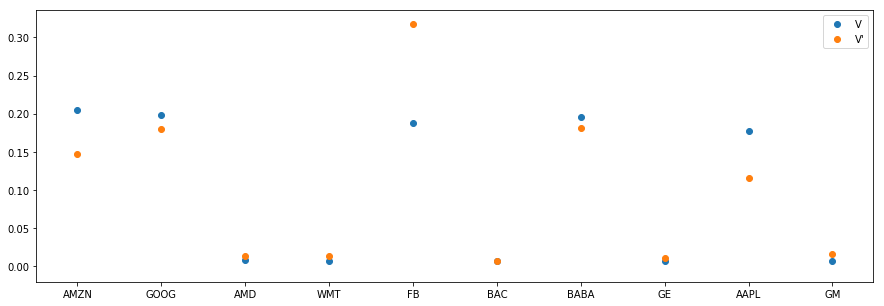

In [60]:
plt.figure(figsize = (15, 5))
plt.scatter(hrp.weights.columns, hrp.weights, label = "V")
plt.scatter(hrp_modified.weights.columns, hrp_modified.weights, label = "V'")
plt.legend()
plt.show()

### (ii) CLA

In [49]:
def _infnone(x):
    return float("-inf") if x is None else x


class CLAModified:
    def __init__(self, weight_bounds=(0, 1), calculate_returns="mean"):
        '''
        Initialise the storage arrays and some preprocessing.

        :param weight_bounds: (tuple) a tuple specifying the lower and upper bound ranges for the portfolio weights
        :param calculate_returns: (str) the method to use for calculation of expected returns.
                                        Currently supports "mean" and "exponential"
        '''

        self.weight_bounds = weight_bounds
        self.calculate_returns = calculate_returns

    def _calculate_mean_historical_returns(self, X, frequency=252):
        '''
        Calculate the annualised mean historical returns from asset price data

        :param X: (pd.DataFrame) asset price data
        :return: (np.array) returns per asset
        '''

        returns = X.pct_change().dropna(how="all")
        returns = returns.mean() * frequency
        return returns

    def _calculate_exponential_historical_returns(self, X, frequency=252, span=500):
        '''
        Calculate the exponentially-weighted mean of (daily) historical returns, giving
        higher weight to more recent data.

        :param X: (pd.DataFrame) asset price data
        :return: (np.array) returns per asset
        '''

        returns = X.pct_change().dropna(how="all")
        returns = returns.ewm(span=span).mean().iloc[-1] * frequency
        return returns

    def _init_algo(self):
        '''
        Initial setting up of the algorithm. Calculates the first free weight of the first turning point.

        :return: (list, list) asset index and the corresponding free weight value
        '''

        # Form structured array
        structured_array = np.zeros((self.expected_returns.shape[0]), dtype=[("id", int), ("mu", float)])
        expected_returns = [self.expected_returns[i][0] for i in range(self.expected_returns.shape[0])]  # dump array into list

        # Fill structured array
        structured_array[:] = list(zip(list(range(self.expected_returns.shape[0])), expected_returns))

        # Sort structured array based on increasing return value
        expected_returns = np.sort(structured_array, order="mu")

        # First free weight
        i, w = expected_returns.shape[0], np.copy(self.lower_bounds)
        while np.sum(w) < 1:
            i -= 1

            # Set weights one by one to the upper bounds
            w[expected_returns[i][0]] = self.upper_bounds[expected_returns[i][0]]
        w[expected_returns[i][0]] += 1 - np.sum(w)
        return [expected_returns[i][0]], w

    def _compute_bi(self, c, asset_bounds_i):
        '''
        Calculates which bound value to assign to a bounded asset - lower bound or upper bound.

        :param c: (float) a value calculated using the covariance matrices of free weights.
                          Refer to https://pdfs.semanticscholar.org/4fb1/2c1129ba5389bafe47b03e595d098d0252b9.pdf for
                          more information.
        :param asset_bounds_i: (list) a list containing the lower and upper bound values for the ith weight
        :return: bounded weight value
        '''

        bounded_asset_i = 0
        if c > 0:
            bounded_asset_i = asset_bounds_i[1][0]
        if c < 0:
            bounded_asset_i = asset_bounds_i[0][0]
        return bounded_asset_i

    def _compute_w(self, covarF_inv, covar_FB, mean_F, w_B):
        '''
        Compute the turning point associated with the current set of free weights F

        :param covarF_inv: (np.array) inverse of covariance matrix of free assets
        :param covar_FB: (np.array) covariance matrix between free assets and bounded assets
        :param mean_F: (np.array) expected returns of free assets
        :param w_B: (np.array) bounded asset weight values

        :return: (array, array) list of turning point weights and gamma value from the langrange equation
        '''

        # Compute gamma
        ones_F = np.ones(mean_F.shape)
        g_1 = np.dot(np.dot(ones_F.T, covarF_inv), mean_F)
        g_2 = np.dot(np.dot(ones_F.T, covarF_inv), ones_F)
        if w_B is None:
            g, w_1 = float(-self.lambdas[-1] * g_1 / g_2 + 1 / g_2), 0
        else:
            onesB = np.ones(w_B.shape)
            g_3 = np.dot(onesB.T, w_B)
            g_4 = np.dot(covarF_inv, covar_FB)
            w_1 = np.dot(g_4, w_B)
            g_4 = np.dot(ones_F.T, w_1)
            g = float(-self.lambdas[-1] * g_1 / g_2 + (1 - g_3 + g_4) / g_2)

        # Compute weights
        w_2 = np.dot(covarF_inv, ones_F)
        w_3 = np.dot(covarF_inv, mean_F)
        return -w_1 + g * w_2 + self.lambdas[-1] * w_3, g

    def _compute_lambda(self, covarF_inv, covar_FB, mean_F, w_B, i, bi):
        '''
        Calculate the lambda value in the langrange optimsation equation

        :param covarF_inv: (np.array) inverse of covariance matrix of free assets
        :param covar_FB: (np.array) covariance matrix between free assets and bounded assets
        :param mean_F: (np.array) expected returns of free assets
        :param w_B: (np.array) bounded asset weight values
        :param i: (int) asset index
        :param bi: (list) list of upper and lower bounded weight values
        :return: (float) lambda value
        '''

        # Compute C
        ones_F = np.ones(mean_F.shape)
        c1 = np.dot(np.dot(ones_F.T, covarF_inv), ones_F)
        c2 = np.dot(covarF_inv, mean_F)
        c3 = np.dot(np.dot(ones_F.T, covarF_inv), mean_F)
        c4 = np.dot(covarF_inv, ones_F)
        c = -c1 * c2[i] + c3 * c4[i]
        if c == 0:
            return None, None

        # Compute bi
        if type(bi) == list:
            bi = self._compute_bi(c, bi)

        # Compute Lambda
        if w_B is None:

            # All free assets
            return float((c4[i] - c1 * bi) / c), bi
        else:
            onesB = np.ones(w_B.shape)
            l1 = np.dot(onesB.T, w_B)
            l2 = np.dot(covarF_inv, covar_FB)
            l3 = np.dot(l2, w_B)
            l2 = np.dot(ones_F.T, l3)
            return float(((1 - l1 + l2) * c4[i] - c1 * (bi + l3[i])) / c), bi

    def _get_matrices(self, f):
        '''
        Calculate the required matrices between free and bounded assets

        :param f: (list) list of free assets/weights
        :return: (tuple of np.array matrices) the corresponding matrices
        '''

        covarF = self._reduce_matrix(self.cov_matrix, f, f)
        mean_F = self._reduce_matrix(self.expected_returns, f, [0])
        b = self._get_b(f)
        covar_FB = self._reduce_matrix(self.cov_matrix, f, b)
        w_B = self._reduce_matrix(self.weights[-1], b, [0])
        return covarF, covar_FB, mean_F, w_B

    def _get_b(self, f):
        '''
        Compute the list of bounded assets

        :param f: (np.array) list of free weights/assets
        :return: (np.array) list of bounded assets/weights
        '''

        return self._diff_lists(list(range(self.expected_returns.shape[0])), f)

    @staticmethod
    def _diff_lists(list1, list2):
        '''
        Calculate the set difference between two lists
        '''

        return list(set(list1) - set(list2))

    @staticmethod
    def _reduce_matrix(matrix, listX, listY):
        '''
        Reduce a matrix to the provided set of rows and columns
        '''

        return matrix[np.ix_(listX, listY)]

    def _purge_num_err(self, tol):
        '''
        Purge violations of inequality constraints (associated with ill-conditioned cov matrix)
        '''

        i = 0
        while True:
            flag = False
            if i == len(self.weights):
                break
            if abs(sum(self.weights[i]) - 1) > tol:
                flag = True
            else:
                for j in range(self.weights[i].shape[0]):
                    if (
                            self.weights[i][j] - self.lower_bounds[j] < -tol
                            or self.weights[i][j] - self.upper_bounds[j] > tol
                    ):
                        flag = True
                        break
            if flag is True:
                del self.weights[i]
                del self.lambdas[i]
                del self.gammas[i]
                del self.free_weights[i]
            else:
                i += 1

    def _purge_excess(self):
        '''
        Remove violations of the convex hull
        '''

        i, repeat = 0, False
        while True:
            if repeat is False:
                i += 1
            if i == len(self.weights) - 1:
                break
            w = self.weights[i]
            mu = np.dot(w.T, self.expected_returns)[0, 0]
            j, repeat = i + 1, False
            while True:
                if j == len(self.weights):
                    break
                w = self.weights[j]
                mu_ = np.dot(w.T, self.expected_returns)[0, 0]
                if mu < mu_:
                    del self.weights[i]
                    del self.lambdas[i]
                    del self.gammas[i]
                    del self.free_weights[i]
                    repeat = True
                    break
                else:
                    j += 1

    def _golden_section(self, obj, a, b, **kargs):
        '''
        Golden section method. Maximum if kargs['minimum']==False is passed
        '''

        tol, sign, args = 1.0e-9, 1, None
        if "minimum" in kargs and kargs["minimum"] is False:
            sign = -1
        if "args" in kargs:
            args = kargs["args"]
        numIter = int(ceil(-2.078087 * log(tol / abs(b - a))))
        r = 0.618033989
        c = 1.0 - r

        # Initialize
        x1 = r * a + c * b
        x2 = c * a + r * b
        f1 = sign * obj(x1, *args)
        f2 = sign * obj(x2, *args)

        # Loop
        for i in range(numIter):
            if f1 > f2:
                a = x1
                x1 = x2
                f1 = f2
                x2 = c * a + r * b
                f2 = sign * obj(x2, *args)
            else:
                b = x2
                x2 = x1
                f2 = f1
                x1 = r * a + c * b
                f1 = sign * obj(x1, *args)
        if f1 < f2:
            return x1, sign * f1
        else:
            return x2, sign * f2

    def _eval_sr(self, a, w0, w1):
        '''
        Evaluate SR of the portfolio within the convex combination
        '''

        w = a * w0 + (1 - a) * w1
        b = np.dot(w.T, self.expected_returns)[0, 0]
        c = np.dot(np.dot(w.T, self.cov_matrix), w)[0, 0] ** 0.5
        return b / c

    def _bound_free_weight(self, free_weights):
        '''
        Add a free weight to list of bounded weights
        '''

        lambda_in = None
        i_in = None
        bi_in = None
        if len(free_weights) > 1:
            covarF, covar_FB, mean_F, w_B = self._get_matrices(free_weights)
            covarF_inv = np.linalg.inv(covarF)
            j = 0
            for i in free_weights:
                l, bi = self._compute_lambda(
                    covarF_inv, covar_FB, mean_F, w_B, j, [self.lower_bounds[i], self.upper_bounds[i]]
                )
                if _infnone(l) > _infnone(lambda_in):
                    lambda_in, i_in, bi_in = l, i, bi
                j += 1
        return lambda_in, i_in, bi_in

    def _free_bound_weight(self, free_weights):
        '''
        Add a bounded weight to list of free weights
        '''

        lambda_out = None
        i_out = None
        if len(free_weights) < self.expected_returns.shape[0]:
            b = self._get_b(free_weights)
            for i in b:
                covarF, covar_FB, mean_F, w_B = self._get_matrices(free_weights + [i])
                covarF_inv = np.linalg.inv(covarF)
                l, bi = self._compute_lambda(
                    covarF_inv,
                    covar_FB,
                    mean_F,
                    w_B,
                    mean_F.shape[0] - 1,
                    self.weights[-1][i],
                )
                if (self.lambdas[-1] is None or l < self.lambdas[-1]) and l > _infnone(lambda_out):
                    lambda_out, i_out = l, i
        return lambda_out, i_out

    def _initialise(self, asset_prices):

        # Handle non-dataframes
        if not isinstance(asset_prices, pd.DataFrame):
            asset_prices = pd.DataFrame(asset_prices)

        # Calculate the expected returns
        if self.calculate_returns == "mean":
            self.expected_returns = self._calculate_mean_historical_returns(X=asset_prices)
        else:
            self.expected_returns = self._calculate_exponential_historical_returns(X=asset_prices)
        self.expected_returns = np.array(self.expected_returns).reshape((len(self.expected_returns), 1))
        if (self.expected_returns == np.ones(self.expected_returns.shape) * self.expected_returns.mean()).all():
            self.expected_returns[-1, 0] += 1e-5

        # Calculate the covariance matrix
        self.cov_matrix = V_modified

        if isinstance(self.weight_bounds[0], numbers.Real):
            self.lower_bounds = np.ones(self.expected_returns.shape) * self.weight_bounds[0]
        else:
            self.lower_bounds = np.array(self.weight_bounds[0]).reshape(self.expected_returns.shape)

        if isinstance(self.weight_bounds[0], numbers.Real):
            self.upper_bounds = np.ones(self.expected_returns.shape) * self.weight_bounds[1]
        else:
            self.upper_bounds = np.array(self.weight_bounds[1]).reshape(self.expected_returns.shape)

        # Initialise storage buffers
        self.weights = []
        self.lambdas = []
        self.gammas = []
        self.free_weights = []

    def _max_sharpe(self):
        '''
        Compute the maximum sharpe portfolio allocation

        :return: (float, np.array) tuple of max. sharpe value and the set of weight allocations
        '''

        # 1) Compute the local max SR portfolio between any two neighbor turning points
        w_sr, sr = [], []
        for i in range(len(self.weights) - 1):
            w0 = np.copy(self.weights[i])
            w1 = np.copy(self.weights[i + 1])
            kargs = {"minimum": False, "args": (w0, w1)}
            a, b = self._golden_section(self._eval_sr, 0, 1, **kargs)
            w_sr.append(a * w0 + (1 - a) * w1)
            sr.append(b)
        return max(sr), w_sr[sr.index(max(sr))]

    def _min_volatility(self):
        '''
        Compute minimum volatility portfolio allocation

        :return: (float, np.array) tuple of minimum variance value and the set of weight allocations
        '''

        var = []
        for w in self.weights:
            a = np.dot(np.dot(w.T, self.cov_matrix), w)
            var.append(a)
        min_var = min(var)
        return min_var ** .5, self.weights[var.index(min_var)]

    def _efficient_frontier(self, points=100):
        '''
        Compute the entire efficient frontier solution

        :param points: (int) number of efficient frontier points to be calculated
        :return: tuple of mean, variance amd weights of the frontier solutions
        '''

        mu, sigma, weights = [], [], []

        # remove the 1, to avoid duplications
        a = np.linspace(0, 1, points // len(self.weights))[:-1]
        b = list(range(len(self.weights) - 1))
        for i in b:
            w0, w1 = self.weights[i], self.weights[i + 1]
            if i == b[-1]:
                # include the 1 in the last iteration
                a = np.linspace(0, 1, points // len(self.weights))
            for j in a:
                w = w1 * j + (1 - j) * w0
                weights.append(np.copy(w))
                mu.append(np.dot(w.T, self.expected_returns)[0, 0])
                sigma.append(np.dot(np.dot(w.T, self.cov_matrix), w)[0, 0] ** 0.5)
        return mu, sigma, weights

    def allocate(self, asset_prices, solution="cla_turning_points"):
        '''
        Calculate the solution of turning points satisfying the weight bounds

        :param asset_prices: (pd.Dataframe/np.array) a dataframe of historical asset prices (adj closed)
        :param solution: (str) specify the type of solution to compute. Options are: cla_turning_points, max_sharpe,
                               min_volatility, efficient_frontier
        '''

        # Some initial steps before the algorithm runs
        self._initialise(asset_prices=asset_prices)
        assets = asset_prices.columns

        # Compute the turning points,free sets and weights
        free_weights, w = self._init_algo()
        self.weights.append(np.copy(w))  # store solution
        self.lambdas.append(None)
        self.gammas.append(None)
        self.free_weights.append(free_weights[:])
        while True:

            # 1) Bound one free weight
            lambda_in, i_in, bi_in = self._bound_free_weight(free_weights)

            # 2) Free one bounded weight
            lambda_out, i_out = self._free_bound_weight(free_weights)

            if (lambda_in is None or lambda_in < 0) and (lambda_out is None or lambda_out < 0):
                # 3) Compute minimum variance solution
                self.lambdas.append(0)
                covarF, covar_FB, mean_F, w_B = self._get_matrices(free_weights)
                covarF_inv = np.linalg.inv(covarF)
                mean_F = np.zeros(mean_F.shape)
            else:
                # 4) Decide whether to free a bounded weight or bound a free weight
                if _infnone(lambda_in) > _infnone(lambda_out):
                    self.lambdas.append(lambda_in)
                    free_weights.remove(i_in)
                    w[i_in] = bi_in  # set value at the correct boundary
                else:
                    self.lambdas.append(lambda_out)
                    free_weights.append(i_out)
                covarF, covar_FB, mean_F, w_B = self._get_matrices(free_weights)
                covarF_inv = np.linalg.inv(covarF)

            # 5) Compute solution vector
            wF, g = self._compute_w(covarF_inv, covar_FB, mean_F, w_B)
            for i in range(len(free_weights)):
                w[free_weights[i]] = wF[i]
            self.weights.append(np.copy(w))  # store solution
            self.gammas.append(g)
            self.free_weights.append(free_weights[:])
            if self.lambdas[-1] == 0:
                break

        # 6) Purge turning points
        self._purge_num_err(10e-10)
        self._purge_excess()

        # Compute the specified corresponding solution
        if solution == "max_sharpe":
            self.max_sharpe, self.weights = self._max_sharpe()
            self.weights = pd.DataFrame(self.weights)
            self.weights.index = assets
            self.weights = self.weights.T
        elif solution == "min_volatility":
            self.min_var, self.weights = self._min_volatility()
            self.weights = pd.DataFrame(self.weights)
            self.weights.index = assets
            self.weights = self.weights.T
        elif solution == "efficient_frontier":
            self.mu, self.sigma, self.weights = self._efficient_frontier()
            weights_copy = self.weights.copy()
            for i, turning_point in enumerate(weights_copy):
                self.weights[i] = turning_point.reshape(1, -1)[0]
            self.weights = pd.DataFrame(self.weights, columns=assets)
        else:
            # Reshape the weight matrix
            weights_copy = self.weights.copy()
            for i, turning_point in enumerate(weights_copy):
                self.weights[i] = turning_point.reshape(1, -1)[0]
            self.weights = pd.DataFrame(self.weights, columns=assets)
            


In [50]:
cla_modified = CLAModified()
cla_modified.allocate(asset_prices=data_downsampled, solution='cla_turning_points')

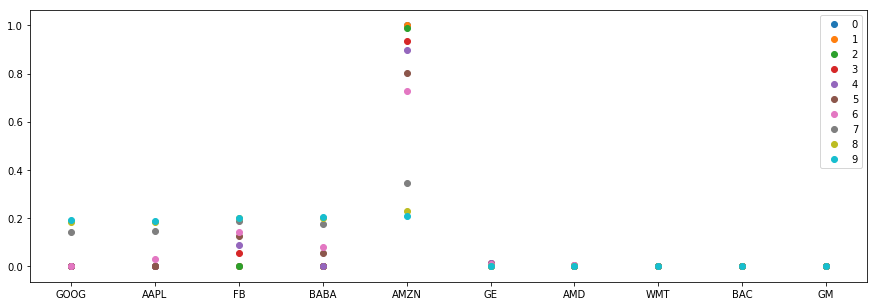

In [51]:
plt.figure(figsize = (15, 5))
for weight_index in range(cla.weights.shape[0]):
    plt.scatter(cla.weights.columns, cla.weights.iloc[weight_index, :], label = str(weight_index))
plt.legend()
plt.show()

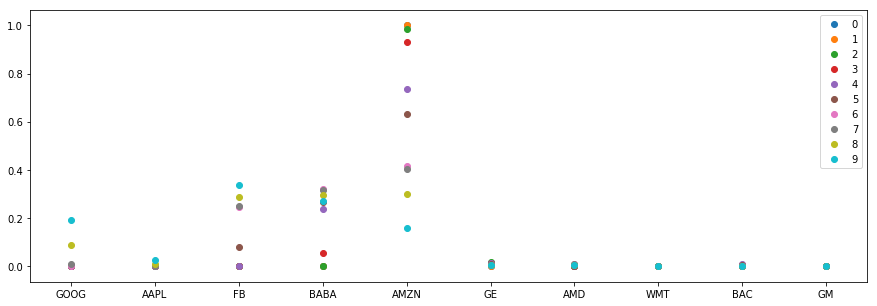

In [52]:
plt.figure(figsize = (15, 5))
for weight_index in range(cla_modified.weights.shape[0]):
    plt.scatter(cla_modified.weights.columns, cla_modified.weights.iloc[weight_index, :], label = str(weight_index))
plt.legend()
plt.show()

### (iii) IVP

In [53]:
class MeanVarianceOptimisationModified:

    def __init__(self):
        return

    def allocate(self, asset_prices, solution='inverse_variance'):
        '''

        :param asset_prices: (pd.Dataframe/np.array) the matrix of historical asset prices (daily close)
        :param solution: (str) the type of solution/algorithm to use to calculate the weights
        '''

        if not isinstance(asset_prices, pd.DataFrame):
            asset_prices = pd.DataFrame(asset_prices)

        self.weights = []
        assets = asset_prices.columns
        if solution == 'inverse_variance':
            self.weights = self._inverse_variance(asset_prices=asset_prices)
        self.weights = pd.DataFrame(self.weights)
        self.weights.index = assets
        self.weights = self.weights.T

    def _inverse_variance(self, asset_prices):
        '''

        :param asset_prices: (pd.Dataframe/np.array) the matrix of historical asset prices (daily close)
        :return: (np.array) array of portfolio weights
        '''

        cov = V_modified
        ivp = 1. / np.diag(cov)
        ivp /= ivp.sum()
        return ivp

In [54]:
mvo_modified = MeanVarianceOptimisationModified()
mvo_modified.allocate(asset_prices = data_downsampled, solution = 'inverse_variance')

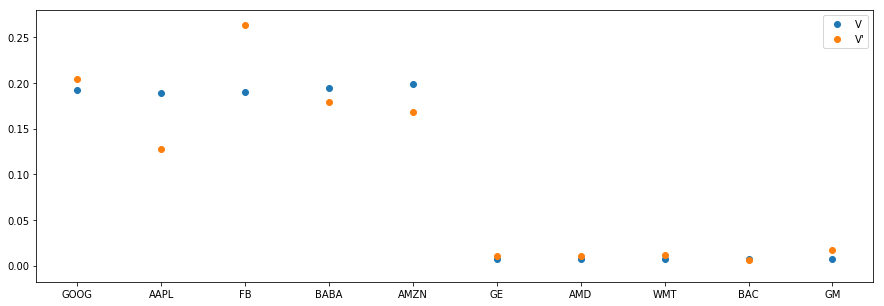

In [59]:
plt.figure(figsize = (15, 5))
plt.scatter(mvo.weights.columns, mvo.weights, label = 'V')
plt.scatter(mvo_modified.weights.columns, mvo_modified.weights, label = "V'")
plt.legend()
plt.show()

## Question-16.4

### How would you modify the HRP algorithm to produce allocations that add up to 0, where |$w_{n}$| ≤ 1, ∀n = 1,…,N?

In [72]:
-0.1 + 0.5 + 0.3 - 0.1

0.4000000000000001

In [105]:
class HierarchicalRiskParityNegativeWeights:

    def __init__(self):
        return

    def _tree_clustering(self, correlation, method='single'):
        '''
        Perform the traditional heirarchical tree clustering

        :param correlation: (np.array) correlation matrix of the assets
        :param method: (str) the type of clustering to be done
        :return: distance matrix and clusters
        '''

        distances = np.sqrt((1 - correlation) / 2)
        clusters = linkage(squareform(distances.values), method=method)
        return distances, clusters

    def _quasi_diagnalization(self, N, curr_index):
        '''
        Rearrange the assets to reorder them according to hierarchical tree clustering order.

        :param N: (int) index of element in the cluster list
        :param curr_index: (int) current index
        :return: (list) the assets rearranged according to hierarchical clustering
        '''

        if curr_index < N:
            return [curr_index]

        left = int(self.clusters[curr_index - N, 0])
        right = int(self.clusters[curr_index - N, 1])

        return (self._quasi_diagnalization(N, left) + self._quasi_diagnalization(N, right))

    def _get_seriated_matrix(self, assets, distances, correlations):
        '''
        Based on the quasi-diagnalization, reorder the original distance matrix, so that assets within
        the same cluster are grouped together.

        :param assets:
        :param distances:
        :param correlations:
        :return: (np.array) re-arranged distance matrix based on tree clusters
        '''

        ordering = assets[self.ordered_indices]
        seriated_distances = distances.loc[ordering, ordering]
        seriated_correlations = correlations.loc[ordering, ordering]
        return seriated_distances, seriated_correlations

    def _recursive_bisection(self, covariances, assets):
        '''
        Recursively assign weights to the clusters - ultimately assigning weights to the inidividual assets

        :param covariances: (np.array) the covariance matrix
        :param assets:
        '''

        self.weights = pd.Series(1, index=self.ordered_indices)
        clustered_alphas = [self.ordered_indices]

        while len(clustered_alphas) > 0:
            clustered_alphas = [cluster[start:end]
                                for cluster in clustered_alphas
                                for start, end in ((0, len(cluster) // 2), (len(cluster) // 2, len(cluster)))
                                if len(cluster) > 1]

            for subcluster in range(0, len(clustered_alphas), 2):
                left_cluster = clustered_alphas[subcluster]
                right_cluster = clustered_alphas[subcluster + 1]

                # Get left cluster variance
                left_subcovar = covariances.iloc[left_cluster, left_cluster]
                inv_diag = 1 / np.diag(left_subcovar.values)
                parity_w = inv_diag * (1 / np.sum(inv_diag))
                left_cluster_var = np.dot(parity_w, np.dot(left_subcovar, parity_w))

                # Get right cluster variance
                right_subcovar = covariances.iloc[right_cluster, right_cluster]
                inv_diag = 1 / np.diag(right_subcovar.values)
                parity_w = inv_diag * (1 / np.sum(inv_diag))
                right_cluster_var = np.dot(parity_w, np.dot(right_subcovar, parity_w))

                # Calculate allocation factor and weights
                alloc_factor = 1 - left_cluster_var / (left_cluster_var + right_cluster_var)
                self.weights[left_cluster] *= -(alloc_factor)
                self.weights[right_cluster] *= -(1 - alloc_factor)

        # Assign actual asset values to weight index
        self.weights.index = assets[self.ordered_indices]
        self.weights = pd.DataFrame(self.weights)
        self.weights = self.weights.T

    def plot_clusters(self, height=10, width=10):
        '''
        Plot a dendrogram of the hierarchical clusters

        :param height: (int) height of the plot
        :param width: (int) width of the plot
        '''

        plt.figure(figsize=(width, height))
        dendrogram(self.clusters)
        plt.show()

    def allocate(self, asset_prices):
        '''
        Calculate asset allocations using HRP algorithm

        :param asset_prices: (pd.Dataframe/np.array) the matrix of historical asset prices (daily close)
        '''

        if type(asset_prices) != pd.DataFrame:
            asset_prices = pd.DataFrame(asset_prices)

        N = asset_prices.shape[1]
        assets = asset_prices.columns
        cov, corr = pd.DataFrame(V_modified), asset_prices.corr()

        # Step-1: Tree Clustering
        distances, self.clusters = self._tree_clustering(correlation=corr)

        # Step-2: Quasi Diagnalization
        self.ordered_indices = self._quasi_diagnalization(N, 2 * N - 2)
        self.seriated_distances, self.seriated_correlations = self._get_seriated_matrix(assets=assets,
                                                                                        distances=distances,
                                                                                        correlations=corr)

        # Step-3: Recursive Bisection
        self._recursive_bisection(covariances=cov, assets=assets)

The change we make in the HRP algorithm is that instead of assigning a positive allocation factor to the clusters, we will assign negative allocation factors. You can look at the snippet in the **recursive_bisection** function where the allocation factor is calculated and assigned.

In [106]:
hrp_negative = HierarchicalRiskParityNegativeWeights()
hrp_negative.allocate(asset_prices = data_downsampled)

In [112]:
hrp_negative.weights

,AMZN,GOOG,AMD,WMT,FB,BAC,BABA,GE,AAPL,GM
0,-0.146958,-0.179353,-0.013607,0.013876,0.317164,-0.006681,-0.181586,-0.01024,0.115008,0.015526


Lets calculate the normal summation of these weights taking into account their sign

In [107]:
np.sum(hrp_negative.weights.values)

-0.07685092351170483

And now lets calculate the absolute sum of the weights

In [111]:
np.sum(np.abs(hrp_negative.weights.values))

0.9999999999999999

We see that their absolute sum is 0.99(~1) and their normal summation is -0.07